<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**CONTESTO:**
Si prevede che la nostra popolazione mondiale crescerà dai 7,3 miliardi di oggi a 9,7 miliardi nell'anno 2050. Trovare soluzioni per nutrire la popolazione mondiale in crescita è diventato un tema scottante per le organizzazioni, gli imprenditori e i filantropi dell'agricoltura e dell'alimentazione.

Queste soluzioni vanno dal cambiamento del modo in cui coltiviamo e alleviamo il nostro cibo al cambiamento del modo in cui mangiamo. 
Per rendere le cose più difficili, il clima della Terra sta cambiando ed è influenzato dall'agricoltura. Poiché la popolazione mondiale si è espansa e si è arricchita, la domanda di cibo, energia e acqua ha visto un rapido aumento.
Non solo è aumentata la domanda per tutti e tre, ma sono anche fortemente interconnessi: la produzione alimentare richiede acqua ed energia; la produzione energetica tradizionale richiede risorse idriche; l'agricoltura fornisce una potenziale fonte di energia e tanta acqua. 
 
 
**OBIETTIVO:** 
A partire dai dati inerenti alla produzione e distribuzione mondiale di alimenti e mangimi si analizzi l'impatto negativo che questi hanno sull'ambiente. Una volta terminata l'EDA, utilizza i metodi di scaling ed encoding visti a lezione per preparare al meglio il dataset per un ipotetico modello predittivo ( vedi data preprocessing ) :

qui di seguito alcune domande per ispirarti

- quali sono i 5 alimenti e mangimi che hanno l'impatto peggiore sull'ambiente ?
- qual è il paese che nel tempo è più riuscito a diminuire l'impatto negativo della propria produzione e distribuzione di alimenti e mangimi?


**Dati a disposizione:**

- A questo link (https://www.kaggle.com/datasets/dorbicycle/world-foodfeed-production), sul sito di Kaggle, trovi il primo dataset utile che fornisce una panoramica della nostra produzione alimentare mondiale, concentrandosi su un confronto tra alimenti prodotti per il consumo umano e mangimi prodotti per animali.

- Questo dataset è messo a disposizione dall’Organizzazione delle Nazioni Unite, che per l'alimentazione e l'agricoltura fornisce libero accesso ai dati su cibo e agricoltura per oltre 245 paesi e territori (il csv nominato 'FAOSTAT_data_3-24-2022' in allegato alla traccia), dall'anno 1961 all'aggiornamento più recente.

- Mentre il secondo dataset utile presente a questo link (https://www.kaggle.com/selfvivek/environment-impact-of-food-production) contiene i 43 alimenti più comuni coltivati ​​in tutto il mondo e 23 colonne che descrivono valori come l’utilizzo dell'acqua ed emissioni di gas serra.

In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.offline as po
import plotly.express as px


pd.set_option('display.max_rows', 2536)
pd.set_option('display.max_columns', 100)

In [2]:
fao_raw = pd.read_csv("FAO.csv", encoding='Windows-1252') # Rappresenta la produzione di cibi espressa in 1000T 
faostat_raw = pd.read_csv("FAOSTAT_data_3-24-2022.csv") # Dataframe con le variazioni di temperatura dal 1961
fp_raw = pd.read_csv("Food_Production.csv") # Dataframe con le emissioni generate cibo per cibo

### Data cleaning and setup

In [3]:
#ALL dfs
fao_raw.rename(columns=str.lower, inplace=True)
faostat_raw.rename(columns=str.lower, inplace=True)
fp_raw.rename(columns=str.lower, inplace=True)

Check null values

In [4]:
#fp_raw.head(44)

Fill nan values of years with the mean of all years

In [5]:
fao_s1 = fao_raw.apply(lambda row: row.fillna(row[10:].mean()), axis=1) # Gli anni dove manca un dato vengono riempiti con la media dello stato
faostat_s1 = faostat_raw.fillna(0) # dove manca un dato nei cambi di temperatura viene messo 0
fp_s1 = fp_raw.fillna(0) # I prodotti con emissioni nulle hanno emissioni 0

Remove rows with negative values

In [6]:
rows = fao_s1[(fao_s1.loc[:, 'y1961':'y2013'] < 0).any(axis=1)]
fao_s1.drop(rows.index, inplace=True)

Romoving rows with all 0 in year fields

In [7]:
idx_drop = fao_s1[(fao_s1.loc[:, "y1961":"y2013"].sum(axis=1) == 0)].index

fao_s1.drop(idx_drop, inplace=True)

Removing duplicates rows

In [8]:
# get index of duplicated rows
idx_drop = fao_s1[fao_s1.duplicated()].index

# remove rows
fao_s1.drop(idx_drop, axis=0, inplace=True)

Cleaning item columns

In [9]:
# Tengo solo la prima parola degli items in FAO
fao_s1['item'] = fao_s1['item'].str.replace(",", "")
fao_s1['item'] = fao_s1['item'].apply(lambda x: x.split(" ")[0])

# Tengo solo la prima parola degli items in Food Production

fp_s1["food product"] = fp_s1["food product"].apply(lambda x: x.split(" ")[0])
fp_s1['food product'] = fp_s1['food product'].str.replace(",", "")

### Analizziamo la produzione di cibi (FAO)

Raggruppo per area geografica (stato) tutte le righe, sommando i valori per gli anni

In [10]:
#Removing useless columns
useless_columns = ['area abbreviation', "area", 'area code', 'item code', 'item',
       'element code', 'element', 'unit', 'latitude', 'longitude']
fao_t_per_year = fao_s1.drop(useless_columns, axis=1)

#Get the mean of all productions per year
years_mean = fao_t_per_year.mean(numeric_only=True)

### Analizzo l'andamento della temperatura dal 1961 al 2013 (FAOSTAT)

Rimuovo le colonne non di interesse

In [11]:
useless_columns = ['domain code', 'domain', 'area code', 'area', 'element code', 'element',
       'months code', 'months', 'year code', 'unit', 'flag',
       'flag description']
faostat_s2 = faostat_s1.drop(useless_columns, axis=1)

In [12]:
faostat_year_values = faostat_s2.groupby(["year"]).mean()

In [13]:
fao_t_per_year.rename(columns=lambda x: x[1:], inplace=True)

### Faccio il plot dei due datasets

Creo un grafico che mi mostra l'andamento, negli anni, dell'aumento della temperatura

In [14]:
years = list(set(fao_t_per_year.columns).intersection(set([str(x) for x in faostat_year_values.index])))
years.sort()

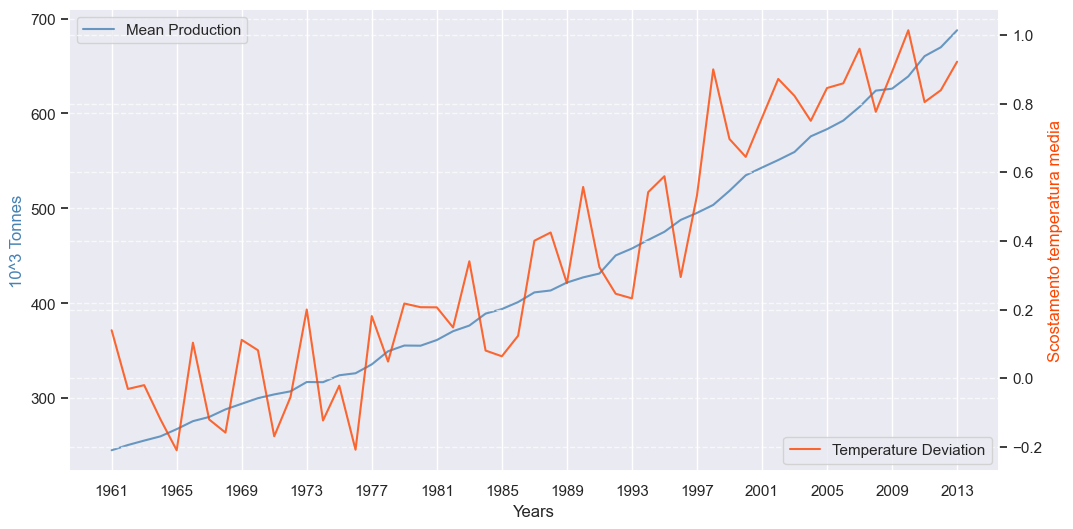

In [60]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.set_xlabel('Years')

ax1.plot(years, years_mean, color='steelblue', alpha=0.8)
ax2.plot(years, faostat_year_values.value.to_list()[:len(years_mean)], color='orangered', alpha=0.8)
ax1.set_xticks([str(x) for x in range(1961, 2014, 4)], rotation=45)

ax1.set_ylabel('10^3 Tonnes', color='steelblue')
ax2.set_ylabel('Scostamento temperatura media', color='orangered')

ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

ax1.legend(['Mean Production'], loc='upper left')
ax2.legend(['Temperature Deviation'], loc='lower right')

plt.show()

### Gli alimenti che hanno impatto peggiore sull'ambiente

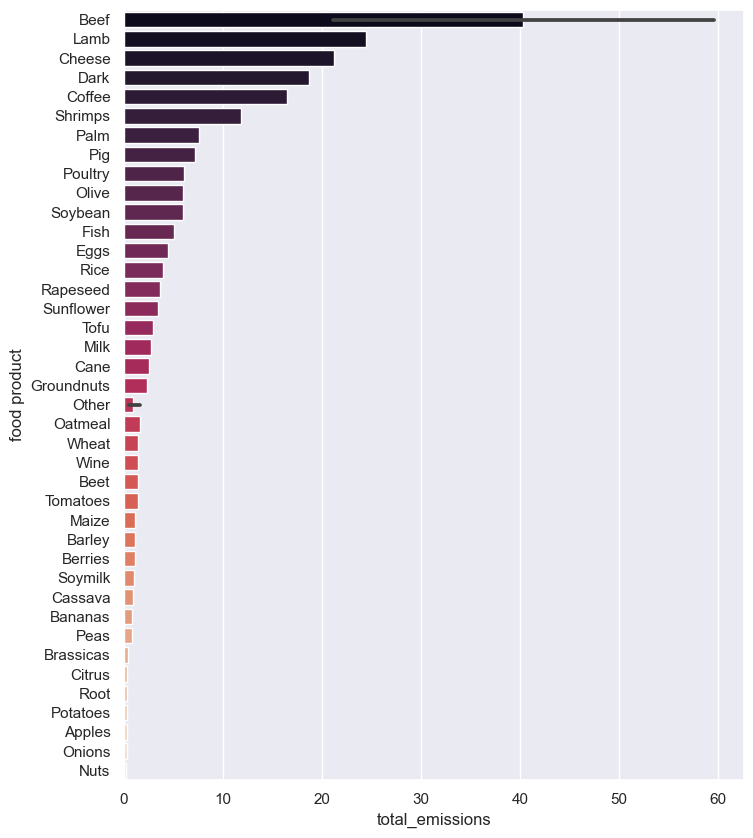

In [16]:
#Ordino il dataset per emissioni in modo discendente
fp_s1_sorted = fp_s1.sort_values(by='total_emissions', ascending=False).reset_index()

# Faccio il plot della classifica
sns.set(rc={'figure.figsize':(8,10)})

sns.barplot(x='total_emissions', y='food product', data=fp_s1_sorted, palette='rocket')
plt.show()

### Troviamo il paese che nel tempo è più riuscito a diminuire l'impatto negativo della propria produzione

#### Calcolo l'impatto totale che ha ogni paese anno per anno
Creo un nuovo dataframe con le emissioni di CO2 paese per paese anno per anno

In [17]:
fao_s1.head()

,area abbreviation,area code,area,item code,item,element code,element,unit,latitude,longitude,y1961,y1962,y1963,y1964,y1965,y1966,y1967,y1968,y1969,y1970,y1971,y1972,y1973,y1974,y1975,y1976,y1977,y1978,y1979,y1980,y1981,y1982,y1983,y1984,y1985,y1986,y1987,y1988,y1989,y1990,y1991,y1992,y1993,y1994,y1995,y1996,y1997,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013
0,AFG,2,Afghanistan,2511,Wheat,5142,Food,1000 tonnes,33.94,67.71,1928.0,1904.0,1666.0,1950.0,2001.0,1808.0,2053.0,2045.0,2154.0,1819.0,1963.0,2215.0,2310.0,2335.0,2434.0,2512.0,2282.0,2454.0,2443.0,2129.0,2133.0,2068.0,1994.0,1851.0,1791.0,1683.0,2194.0,1801.0,1754.0,1640.0,1539.0,1582.0,1840.0,1855.0,1853.0,2177.0,2343.0,2407.0,2463.0,2600.0,2668.0,2776.0,3095.0,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice,5142,Food,1000 tonnes,33.94,67.71,183.0,183.0,182.0,220.0,220.0,195.0,231.0,235.0,238.0,213.0,205.0,233.0,246.0,246.0,255.0,263.0,235.0,254.0,270.0,259.0,248.0,217.0,217.0,197.0,186.0,200.0,193.0,202.0,191.0,199.0,197.0,249.0,218.0,260.0,319.0,254.0,326.0,347.0,270.0,372.0,411.0,448.0,460.0,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley,5521,Feed,1000 tonnes,33.94,67.71,76.0,76.0,76.0,76.0,76.0,75.0,71.0,72.0,73.0,74.0,71.0,70.0,72.0,76.0,77.0,80.0,60.0,65.0,64.0,64.0,60.0,55.0,53.0,51.0,48.0,46.0,46.0,47.0,46.0,43.0,43.0,40.0,50.0,46.0,41.0,44.0,50.0,48.0,43.0,26.0,29.0,70.0,48.0,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley,5142,Food,1000 tonnes,33.94,67.71,237.0,237.0,237.0,238.0,238.0,237.0,225.0,227.0,230.0,234.0,223.0,219.0,225.0,240.0,244.0,255.0,185.0,203.0,198.0,202.0,189.0,174.0,167.0,160.0,151.0,145.0,145.0,148.0,145.0,135.0,132.0,120.0,155.0,143.0,125.0,138.0,159.0,154.0,141.0,84.0,83.0,122.0,144.0,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize,5521,Feed,1000 tonnes,33.94,67.71,210.0,210.0,214.0,216.0,216.0,216.0,235.0,232.0,236.0,200.0,201.0,216.0,228.0,231.0,234.0,240.0,228.0,234.0,228.0,226.0,210.0,199.0,192.0,182.0,173.0,170.0,154.0,148.0,137.0,144.0,126.0,90.0,141.0,150.0,159.0,108.0,90.0,99.0,72.0,35.0,48.0,89.0,63.0,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


In [48]:
# Creo un dataframe che contiene per tutti i paesi e per tutti gli anni il totale delle emissioni 
# Calcolato dal dataframe delle produzioni anno per anno e dal dataframe delle emissioni per prodotto
states_productions_years_items = pd.DataFrame()

#Prendo i dati di interesse dal dataframee fao_s1
states_productions_years_items['area'] = fao_s1['area']
states_productions_years_items['item'] = fao_s1['item']
states_productions_years_items = pd.concat([states_productions_years_items, fao_s1.loc[:, 'y1961':'y2013']], axis=1)

# Rinomino le colonne degli anni (rimuovo la y)
states_productions_years_items.rename(columns=lambda x: x[1:] if str(x).startswith('y') else x, inplace=True)

# Faccio un merge con il dataframe food poductions
states_productions_years_items = states_productions_years_items.merge(fp_s1[['food product', 'total_emissions']], left_on='item', right_on='food product', suffixes=('', 'emissions'))
states_productions_years_items.drop('food product', axis=1, inplace=True)
states_productions_years_items.rename(columns={'total_emissions':'emissions'}, inplace=True)

# Creo un dataframe con le produzioni annuali per stato
states_productions_years = states_productions_years_items[col_of_intrest].groupby('area').sum()
states_productions_years.loc[:, '1961':'2013'] = 1000 * states_productions_years.loc[:, '1961':'2013']
states_productions_years.reset_index(inplace=True)

# Aggiungo la colonna produzione totale
states_productions_years_items['total_production'] = states_productions_years_items.loc[:, '1961':'2013'].sum(axis=1)

# Aggiungo la colonna delle emissioni totali
states_productions_years_items['total_emissions'] = states_productions_years_items['total_production'] * 1000 * states_productions_years_items['emissions']

# Creo un dataframe con le emissioni di tutti i paesi degli anni 1961 e 2013
col_of_intrest = ['area'] + ['item'] + [str(x) for x in range(1961, 2014)]
emissions_differential = pd.DataFrame(columns=col_of_intrest)

emissions_differential['area'] = states_productions_years_items.area
emissions_differential['item'] = states_productions_years_items.item
emissions_differential.loc[:, '1961':'2013'] = states_productions_years_items.loc[:, '1961':'2013'].multiply(states_productions_years_items.emissions * 1000, axis=0)

# Ora raggruppo per area
emissions_differential = emissions_differential.groupby('area').sum(numeric_only=True)
emissions_differential.reset_index(inplace=True)

## Creo la colonna differenziale
emissions_differential['differential'] = emissions_differential['1961'] - emissions_differential['2013']

## Trovo lo stato con differenziale più alto
state = emissions_differential.differential.idxmax()

C:\Users\loren\AppData\Local\Temp\ipykernel_1544\3088720844.py:19: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\loren\AppData\Local\Temp\ipykernel_1544\3088720844.py:35: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



,area,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Afghanistan,4309000.0,4282000.0,4192000.0,4561000.0,4747000.0,4591000.0,5057000.0,5124000.0,5275000.0,4576000.0,4585000.0,4947000.0,5260000.0,5412000.0,5584000.0,5921000.0,5215000.0,5529000.0,5540000.0,5290000.0,5283000.0,5132000.0,5122000.0,4858000.0,4414000.0,3848000.0,4390000.0,4025000.0,3965000.0,4353000.0,4302000.0,4336000.0,4996000.0,5446000.0,5763000.0,6275000.0,6783000.0,7049000.0,7425000.0,6700000.0,5781000.0,7661000.0,7917000.0,8264000.0,8394000.0,8646000.0,9203000.0,9253000.0,9674000.0,9806000.0,9857000.0,10527000,10775000
1,Albania,739000.0,761000.0,788000.0,806000.0,826000.0,891000.0,939000.0,971000.0,985000.0,1018000.0,1069000.0,1101000.0,1154000.0,1219000.0,1283000.0,1374000.0,1465000.0,1519000.0,1519000.0,1529000.0,1692000.0,1727000.0,1831000.0,1786000.0,1675000.0,1766000.0,1747000.0,1848000.0,1941000.0,2093000.0,2169000.0,2404000.0,2565000.0,2990000.0,3328000.0,3314000.0,2889000.0,2881000.0,3015000.0,3066000.0,3144000.0,3219000.0,3297000.0,3295000.0,3359000.0,3427000.0,3237000.0,3365000.0,3365000.0,3578000.0,3673000.0,3699000,3758000
2,Algeria,3215000.0,3145000.0,2929000.0,2994000.0,3187000.0,3249000.0,3390000.0,3803000.0,3888000.0,3944000.0,4117000.0,4581000.0,4746000.0,5374000.0,5991000.0,6342000.0,6852000.0,7463000.0,7800000.0,8662000.0,9384000.0,9979000.0,10689000.0,11102000.0,12610000.0,12769000.0,13335000.0,13372000.0,15007000.0,14271000.0,14621000.0,15185000.0,16717000.0,15903000.0,15946000.0,14931000.0,15361000.0,17082000.0,17331000.0,17626000.0,18783000.0,20050000.0,20538000.0,22208000.0,22378000.0,23111000.0,22589000.0,22919000.0,25595000.0,26467000.0,29531000.0,30419000,30951000
3,Angola,2038000.0,1955000.0,2161000.0,2168000.0,2298000.0,2365000.0,2418000.0,2313000.0,2568000.0,2652000.0,2679000.0,2640000.0,2673000.0,2618000.0,2496000.0,2539000.0,2690000.0,2864000.0,2852000.0,2833000.0,3127000.0,2908000.0,3055000.0,3181000.0,3775000.0,3215000.0,3310000.0,3343000.0,3440000.0,3446000.0,3325000.0,3491000.0,3473000.0,4000000.0,4206000.0,4325000.0,4279000.0,4973000.0,5020000.0,6187000.0,7298000.0,8569000.0,9101000.0,10878000.0,11325000.0,11766000.0,12272000.0,12731000.0,14290000.0,14765000.0,15429000.0,14375000,18845000
4,Antigua and Barbuda,22000.0,20000.0,20000.0,21000.0,21000.0,18000.0,18000.0,20000.0,21000.0,22000.0,21000.0,21000.0,21000.0,22000.0,22000.0,21000.0,23000.0,24000.0,26000.0,30000.0,29000.0,28000.0,27000.0,29000.0,28000.0,27000.0,26000.0,29000.0,32000.0,30000.0,27000.0,29000.0,28000.0,31000.0,32000.0,29000.0,33000.0,32000.0,32000.0,36000.0,35000.0,36000.0,36000.0,32000.0,42000.0,38000.0,46000.0,44000.0,43000.0,44000.0,44000.0,41000,44000


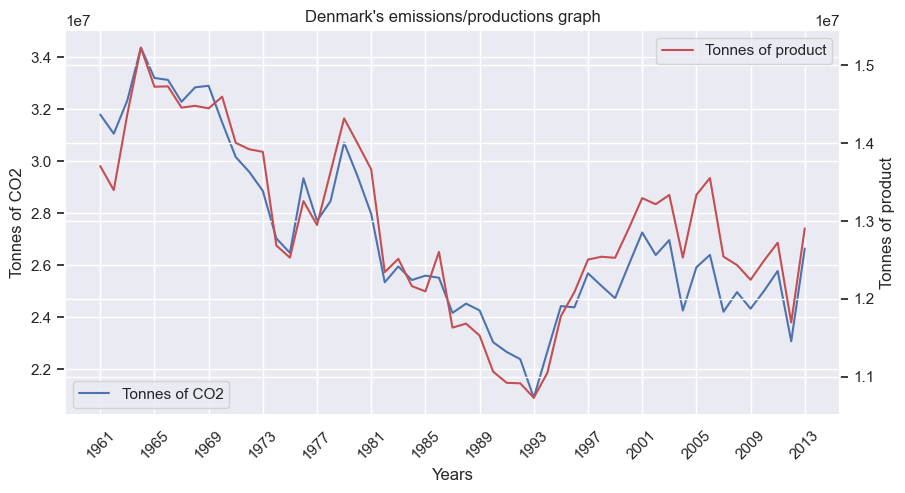

In [68]:
# Faccio il plot dello stato che ha maggiormente ridotto il suo impatto sell'ambiente
fig, ax1 = plt.subplots(figsize=(10, 5))

# Creo un secondo oggetto Axes con gli stessi valori sull'asse x
ax2 = ax1.twinx()

ax1.set_xlabel('Years')
years = [str(x) for x in range(1961, 2014)]

ax1.set_ylabel('Tonnes of CO2')
ax2.set_ylabel('Tonnes of product')

ax1.set_title(emissions_differential.iloc[state].area + '\'s emissions/productions graph')

# Plotto i dati sull'asse y principale (emissione)
ax1.plot(years, emissions_differential.iloc[state, :].values[1:-1])

# Plotto i dati sull'asse y secondario (produzione)
ax2.plot(years, states_productions_years.iloc[state, :].values[1:], color='r')

# Imposto i tick dell'asse x
plt.xticks(years[::4])
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Imposto la legenda
ax1.legend([ax1.get_ylabel()], loc='lower left')
ax2.legend([ax2.get_ylabel()], loc='upper right')

plt.show()

### Trovo lo stato con il rapporto produzione/emissione maggiore

Per fare questo mi serve un dataframe con:

1) Produzione totale (in $10^3$ Tonnellate)
2) Totale delle emissioni (in CO2/Kg)

Tutto questo paese per paese e anno per anno.

In [70]:
# Ottengo il database con le emissioni e le produzioni totali per ogni paese (dall'anno 1961 al 2013)
states_emissions = states_productions_years_items[['area', 'total_production', 'total_emissions']].groupby('area').sum()
states_emissions.reset_index(inplace=True)

# Aggiungo la colonna con il rapporto tra produzione e emisione
states_emissions['P/E'] = states_emissions.total_production / states_emissions.total_emissions
  
# Trovo il rapporto produzione emissione più alto
state = states_emissions['P/E'].idxmax()
print(states_emissions.iloc[state])
states_emissions.head()

area                     Rwanda
total_production       178610.0
total_emissions     167428800.0
P/E                    0.001067
Name: 130, dtype: object


,area,total_production,total_emissions,P/E
0,Afghanistan,320220.0,6.396959e+08,0.000501
1,Albania,113099.0,2.460803e+08,0.000460
2,Algeria,694432.0,1.378490e+09,0.000504
3,Angola,287543.0,3.977909e+08,0.000723
4,Antigua and Barbuda,1553.0,4.717200e+06,0.000329


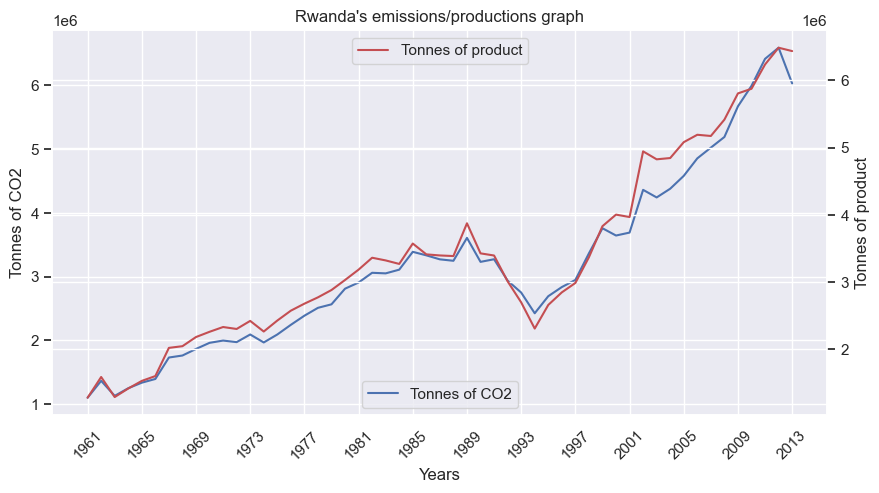

In [73]:
# Faccio il plot dello stato che ha maggiormente ridotto il suo impatto sell'ambiente
fig, ax1 = plt.subplots(figsize=(10, 5))

# Creo un secondo oggetto Axes con gli stessi valori sull'asse x
ax2 = ax1.twinx()

ax1.set_xlabel('Years')
years = [str(x) for x in range(1961, 2014)]

ax1.set_ylabel('Tonnes of CO2')
ax2.set_ylabel('Tonnes of product')

ax1.set_title(emissions_differential.iloc[state].area + '\'s emissions/productions graph')

# Plotto i dati sull'asse y principale (emissione)
ax1.plot(years, emissions_differential.iloc[state, :].values[1:-1])

# Plotto i dati sull'asse y secondario (produzione)
ax2.plot(years, states_productions_years.iloc[state, :].values[1:], color='r')

# Imposto i tick dell'asse x
plt.xticks(years[::4])
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Imposto la legenda
ax1.legend([ax1.get_ylabel()], loc='lower center')
ax2.legend([ax2.get_ylabel()], loc='upper center')

plt.show()

### Scaling delle features 

In [90]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.compose import ColumnTransformer

Visualizziamo un esempio di scatterplot dell'anno 1961 di tutti gli stati

In [76]:
emissions_differential.head()

,area,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,differential
0,Afghanistan,7728200.0,7722000.0,7776900.0,8417000.0,8858000.0,8648200.0,9553600.0,9756500.0,10004900.0,8674700.0,8473200.0,9109200.0,9775100.0,10075500.0,10375700.0,10737500.0,9719400.0,10166400.0,10248900.0,9933000.0,9976900.0,9707000.0,9898400.0,9444300.0,8381600.0,7001600.0,7874900.0,7433300.0,7474800.0,8598200.0,8710000.0,8986300.0,10083700.0,11357600.0,12319500.0,13448400.0,14780100.0,15438200.0,16461800.0,14680000.0,11962200.0,16898500.0,17069800.0,17795600.0,17963400.0,18108400.0,18970900.0,19105500.0,19612500.0,20190800.0,20391500.0,21647800.0,22168500.0,-14440300.0
1,Albania,1475800.0,1526400.0,1577900.0,1638800.0,1674200.0,1757400.0,1827100.0,1863300.0,1902000.0,1990300.0,2133600.0,2199900.0,2371500.0,2464400.0,2560200.0,2698100.0,2903900.0,3053400.0,3091300.0,3169700.0,3419700.0,3528500.0,3698300.0,3639000.0,3463800.0,3579900.0,3650000.0,3894100.0,4071400.0,4483600.0,4767500.0,5195000.0,5609800.0,6837300.0,7983700.0,7535600.0,6377100.0,6346500.0,6736000.0,6868000.0,7091500.0,7359900.0,7610100.0,7563300.0,7667100.0,7820600.0,7402200.0,7642600.0,7658600.0,7959300.0,8118300.0,8241000.0,8381800.0,-6906000.0
2,Algeria,6112400.0,5992200.0,5451500.0,5768900.0,6155700.0,6464500.0,6747900.0,7474500.0,7736300.0,7658500.0,8038200.0,9035300.0,8960800.0,10615900.0,11562400.0,12741100.0,13996200.0,15280900.0,15586000.0,17695900.0,19755400.0,20754800.0,22708700.0,23733300.0,25808200.0,24993300.0,27349900.0,27195900.0,29721600.0,29334200.0,30018500.0,30202500.0,34866900.0,33251500.0,31498800.0,28700900.0,30774800.0,33863500.0,34320700.0,35665600.0,38315800.0,40487300.0,39648100.0,43788900.0,43292300.0,44654900.0,44819000.0,45276100.0,49673900.0,50298800.0,57245000.0,58368500.0,59027200.0,-52914800.0
3,Angola,2739900.0,2726300.0,2917600.0,3046500.0,3152300.0,3231800.0,3430200.0,3277100.0,3542300.0,3696400.0,3664600.0,3550600.0,3583500.0,3594100.0,3426000.0,3661800.0,4223200.0,4643200.0,4777600.0,4584700.0,5501200.0,5060700.0,5445400.0,5775200.0,7308900.0,5600800.0,5902600.0,6029800.0,6079200.0,6144700.0,5442200.0,5396700.0,5316700.0,5718700.0,5881200.0,6163700.0,6319700.0,7184600.0,6993200.0,8581100.0,9618800.0,11000500.0,11492400.0,13452900.0,13944100.0,14475600.0,15433500.0,16165800.0,17214300.0,18760500.0,20010200.0,19745000.0,23161300.0,-20421400.0
4,Antigua and Barbuda,56200.0,50600.0,50600.0,52000.0,52000.0,50000.0,52800.0,55300.0,59800.0,64900.0,59800.0,59800.0,58800.0,60900.0,65700.0,58800.0,65500.0,70500.0,76100.0,83600.0,87200.0,82100.0,78700.0,89900.0,89600.0,89100.0,84000.0,93600.0,101400.0,94900.0,89000.0,93600.0,88300.0,100000.0,100600.0,94600.0,105600.0,101400.0,101900.0,109700.0,107800.0,112900.0,112900.0,101700.0,120800.0,115200.0,142100.0,140400.0,140100.0,141500.0,137600.0,131100.0,134200.0,-78000.0


In [82]:
len(emissions_differential.loc[:, '2013'].values)

174

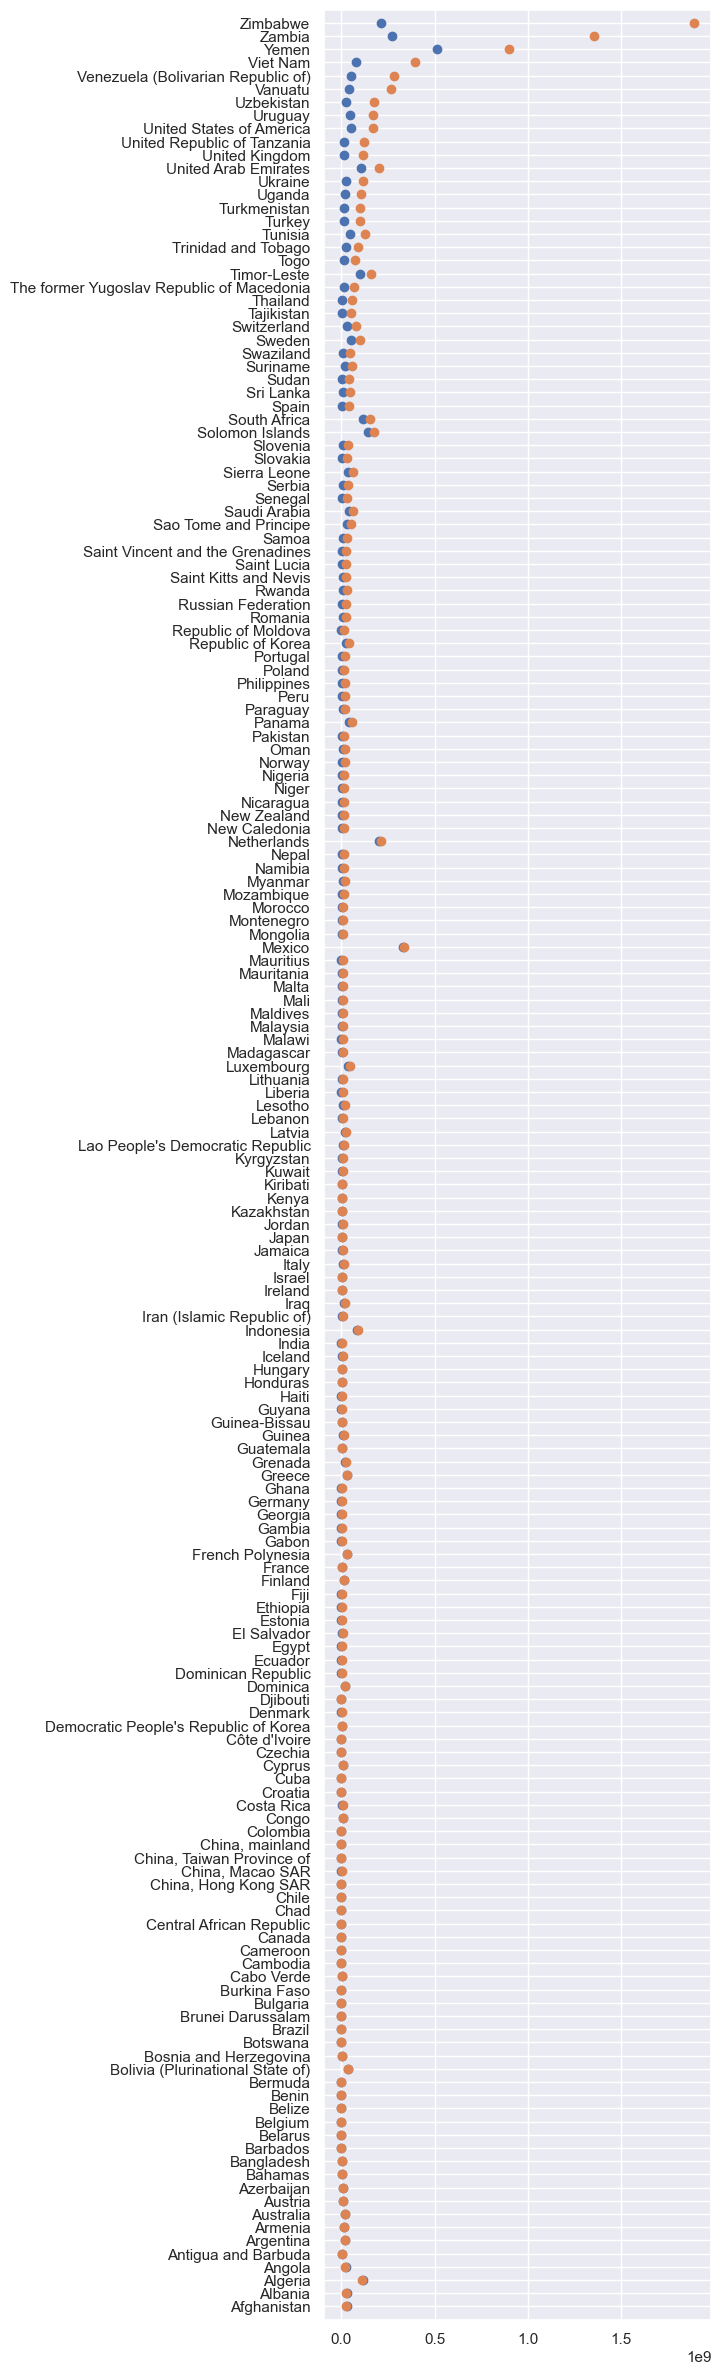

In [87]:
plt.rcParams["figure.figsize"] = (5, 30)

emissions_differential.sort_values('differential', inplace=True, ascending=False)
plt.ylim([-1,len(emissions_differential.index)])
#plt.xlim([0, hits[-1] + 3])
plt.scatter(emissions_differential.loc[:, '1961'].values, states_emissions.area)
plt.scatter(emissions_differential.loc[:, '2013'], states_emissions.area)
plt.show()

Visualizziamo i dati non scalati con uno scatter plot

In [ ]:
emissions_differential.head()

In [ ]:
plt.rcParams["figure.figsize"] = (5, 30)

emissions_differential.sort_values('differential', inplace=True, ascending=False)
plt.ylim([-1,len(emissions_differential.index)])
#plt.xlim([0, hits[-1] + 3])
plt.scatter(emissions_differential.loc[:, '1961'].values, states_emissions.area)
plt.scatter(emissions_differential.loc[:, '2013'], states_emissions.area)
plt.show()

Ok ora scaliamo tutti i valori di tutti i paesi per tutti gli anni con il MinMaxScaler

In [91]:
# Definisco il trasformatore
MM_transformer = ColumnTransformer(
    transformers=[
        ('years', MinMaxScaler(), emissions_differential.columns[1:-1])
    ]
)

# Applico il trasformatore
states_emissions_MM = emissions_differential.copy()

states_emissions_MM.loc[:, '1961':'2013'] = MM_transformer.fit_transform(emissions_differential.loc[:, '1961':'2013'])

In [94]:
# Visualizzazione dei dati scalati in uno scatterplot (outlier)

1.0000000000000002